# 05 — Multi-Model Anomaly Detection Pipeline

Objective:

Detect chokepoint-level anomalies in daily stress indicators (traffic, weather, and geopolitical) using a combination of traditional and deep learning models.
The goal is to identify unusual behavior patterns across 2019–2025 and produce ensemble-based anomaly flags that can inform early-warning systems.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
# Machine Learning Models
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Deep Learning for LSTM Autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# # Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
processed_data_dir = 'processed_data'
master_df_path = os.path.join(processed_data_dir, 'master_df.csv')

master_df = pd.read_csv(master_df_path)
master_df['date'] = pd.to_datetime(master_df['date'])

# Primary features for anomaly detection
features = ['norm_traffic_stress', 'norm_weather_stress', 'norm_geopolitical_risk']

# Ensure data is sorted for time-series processing
master_df = master_df.sort_values(['chokepoint_id', 'date']).reset_index(drop=True)

In [ ]:
# Model 1 - Isolation Forest
print("\n--- Training Model 1: Isolation Forest ---")

iso_forest_results = []
for cp_id in master_df['chokepoint_id'].unique():
    df_cp = master_df[master_df['chokepoint_id'] == cp_id].copy()
    X_cp = df_cp[features]
    
    if len(X_cp) < 2: continue

    model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    predictions = model.fit_predict(X_cp)
    
    df_cp['iso_forest_anomaly'] = predictions
    iso_forest_results.append(df_cp)
    print(f"  ✓ Processed {cp_id}")

# Add results back to the main DataFrame
master_df = pd.merge(master_df, pd.concat(iso_forest_results)[['date', 'chokepoint_id', 'iso_forest_anomaly']], on=['date', 'chokepoint_id'], how='left')
print("--- Isolation Forest training complete. ---")


--- Training Model 1: Isolation Forest ---
  ✓ Processed cp_bab_el_mandeb
  ✓ Processed cp_bosporus
  ✓ Processed cp_malacca
  ✓ Processed cp_panama
  ✓ Processed cp_suez
--- Isolation Forest training complete. ---


In [ ]:
# Model 2 - One-Class SVM
print("\n--- Training Model 2: One-Class SVM ---")

svm_results = []
for cp_id in master_df['chokepoint_id'].unique():
    df_cp = master_df[master_df['chokepoint_id'] == cp_id].copy()
    X_cp = df_cp[features]
    
    if len(X_cp) < 2: continue

    # Scale features for SVM
    scaler = StandardScaler()
    X_cp_scaled = scaler.fit_transform(X_cp)

    model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    predictions = model.fit_predict(X_cp_scaled)
    
    df_cp['svm_anomaly'] = predictions
    svm_results.append(df_cp)
    print(f"  ✓ Processed {cp_id}")

# Add results back to the main DataFrame
master_df = pd.merge(master_df, pd.concat(svm_results)[['date', 'chokepoint_id', 'svm_anomaly']], on=['date', 'chokepoint_id'], how='left')
print("--- One-Class SVM training complete. ---")


--- Training Model 2: One-Class SVM ---
  ✓ Processed cp_bab_el_mandeb
  ✓ Processed cp_bosporus
  ✓ Processed cp_malacca
  ✓ Processed cp_panama
  ✓ Processed cp_suez
--- One-Class SVM training complete. ---


In [ ]:
# Model 3 - LSTM Autoencoder (Helper Functions)
print("\n--- Preparing for Model 3: LSTM Autoencoder ---")

def create_sequences(data, time_steps=10):
    """Creates time-series sequences from a DataFrame."""
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)

def build_lstm_autoencoder(timesteps, n_features):
    """Builds the Keras LSTM Autoencoder model."""
    input_layer = Input(shape=(timesteps, n_features))
    # Encoder
    encoder = LSTM(128, activation='relu', return_sequences=False)(input_layer)
    encoder = RepeatVector(timesteps)(encoder)
    # Decoder
    decoder = LSTM(128, activation='relu', return_sequences=True)(encoder)
    output_layer = TimeDistributed(Dense(n_features))(decoder)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mae')
    return model

TIME_STEPS = 14 # Look at sequences of 14 days
print(f"✓ LSTM helper functions defined. Using a time step of {TIME_STEPS} days.")


--- Preparing for Model 3: LSTM Autoencoder ---
✓ LSTM helper functions defined. Using a time step of 14 days.


In [ ]:
# Model 3 - LSTM Autoencoder

print("\n--- Training Model 3: LSTM Autoencoder ---")

lstm_results = []
trained_lstm_models = {}

for cp_id in master_df['chokepoint_id'].unique():
    df_cp = master_df[master_df['chokepoint_id'] == cp_id].copy()
    
    if len(df_cp) < TIME_STEPS * 2:
        print(f"  ⚠ Skipping {cp_id}: Insufficient data for LSTM.")
        continue
    
    print(f"  Processing {cp_id}...")
    
    scaler = StandardScaler()
    X_cp_scaled = scaler.fit_transform(df_cp[features])
    
    X_sequences = create_sequences(X_cp_scaled, TIME_STEPS)
    
    if X_sequences.shape[0] == 0:
        print(f"  ⚠ Skipping {cp_id}: Not enough data to form sequences.")
        continue

    lstm_autoencoder = build_lstm_autoencoder(TIME_STEPS, len(features))
    # Added EarlyStopping for efficiency and to prevent overfitting
    lstm_autoencoder.fit(X_sequences, X_sequences, epochs=20, batch_size=32, validation_split=0.1, verbose=0,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')])
    
    trained_lstm_models[cp_id] = lstm_autoencoder # Store the model

    reconstructions = lstm_autoencoder.predict(X_sequences)
    # First, calculate the error for each feature at each timestep
    train_mae_loss = np.abs(reconstructions - X_sequences)
    # NOW, average this error across both the timesteps (axis=1) AND the features (axis=2)
    # This results in a single error score per sequence, giving mae_loss the correct (samples,) shape.
    mae_loss = np.mean(train_mae_loss, axis=(1, 2))
    
    # Set anomaly threshold (e.g., 95th percentile of reconstruction error)
    threshold = np.quantile(mae_loss, 0.95)
    
    # Pad the beginning of the predictions (since sequences start later)
    padded_predictions = np.zeros(len(df_cp))
    # Ensure the length matches before assignment for robustness
    num_predictions = len(mae_loss)
    padded_predictions[TIME_STEPS : TIME_STEPS + num_predictions] = (mae_loss > threshold).astype(int)

    # Convert from 0/1 to 1/-1 for consistency
    df_cp['lstm_anomaly'] = np.where(padded_predictions == 1, -1, 1)
    lstm_results.append(df_cp)
    
# Add results back to the main DataFrame
if lstm_results:
    master_df = pd.merge(master_df, pd.concat(lstm_results)[['date', 'chokepoint_id', 'lstm_anomaly']], on=['date', 'chokepoint_id'], how='left')
    master_df['lstm_anomaly'].fillna(1, inplace=True)
    
print("\n--- LSTM Autoencoder training complete. ---")


--- Training Model 3: LSTM Autoencoder ---
  Processing cp_bab_el_mandeb...
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
  Processing cp_bosporus...
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
  Processing cp_malacca...
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step
  Processing cp_panama...
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step
  Processing cp_suez...
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step

--- LSTM Autoencoder training complete. ---


In [ ]:
# Ensemble Consensus and Final Analysis
print("\n--- Creating Ensemble Anomaly Flag and Comparing Models ---")

# Ensure all anomaly columns exist
anomaly_cols = ['iso_forest_anomaly', 'svm_anomaly', 'lstm_anomaly']
for col in anomaly_cols:
    if col not in master_df.columns:
        master_df[col] = 1 # Default to 'normal' if a model failed

# Ensemble Voting
master_df['anomaly_votes'] = (
    (master_df['iso_forest_anomaly'] == -1).astype(int) +
    (master_df['svm_anomaly'] == -1).astype(int) +
    (master_df['lstm_anomaly'] == -1).astype(int)
)
master_df['ensemble_anomaly'] = np.where(master_df['anomaly_votes'] >= 2, -1, 1)

# Create a DataFrame for Model Comparison
models_to_compare = {
    'Isolation Forest': 'iso_forest_anomaly',
    'One-Class SVM': 'svm_anomaly',
    'LSTM Autoencoder': 'lstm_anomaly',
    'Ensemble (≥2 votes)': 'ensemble_anomaly'
}

comparison_data = []
for model_name, col_name in models_to_compare.items():
    if col_name in master_df.columns:
        n_anomalies = (master_df[col_name] == -1).sum()
        pct_anomalies = n_anomalies / len(master_df) * 100
        comparison_data.append({
            'Model': model_name,
            'Anomalies Detected': n_anomalies,
            'Percentage': pct_anomalies
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n--- Global Anomaly Detection Summary ---")
print(comparison_df.to_string(index=False))

ensemble_pct = (master_df['ensemble_anomaly'] == -1).sum() / len(master_df) * 100
print(f"\nFinal Ensemble Anomaly Rate (≥2 votes): {ensemble_pct:.2f}%")


--- Creating Ensemble Anomaly Flag and Comparing Models ---

--- Global Anomaly Detection Summary ---
              Model  Anomalies Detected  Percentage
   Isolation Forest                 620    5.010101
      One-Class SVM                 619    5.002020
   LSTM Autoencoder                 615    4.969697
Ensemble (≥2 votes)                 455    3.676768

Final Ensemble Anomaly Rate (≥2 votes): 3.68%



--- Visualizing Model Comparison ---


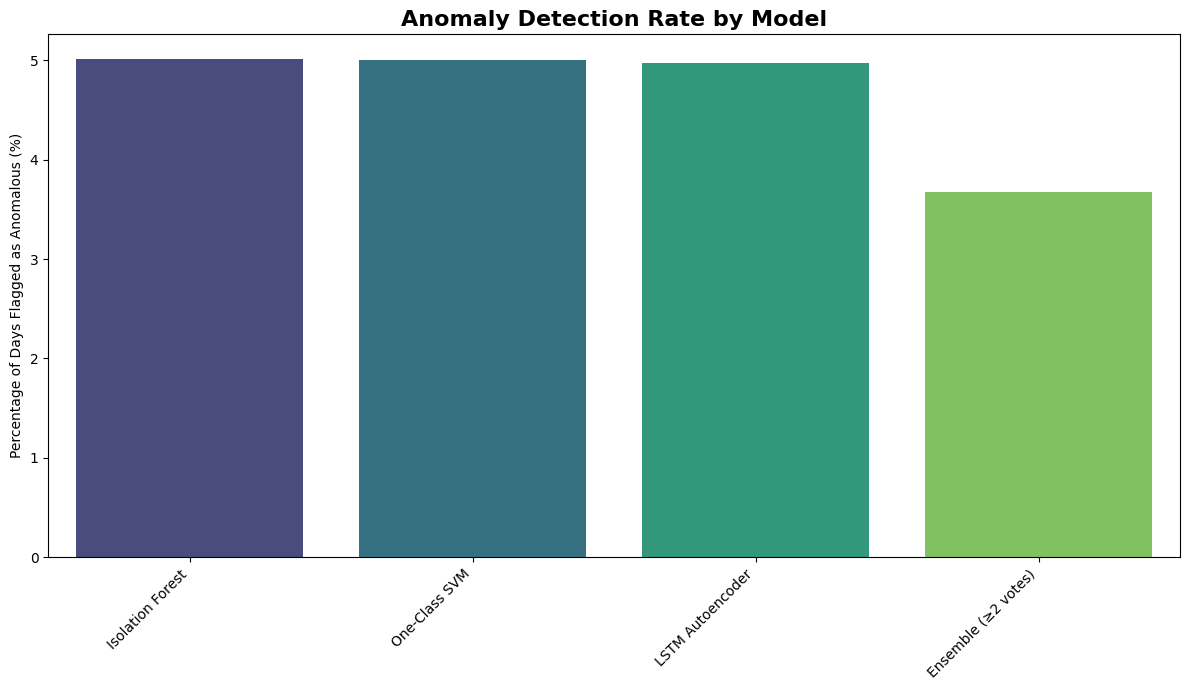

In [ ]:
# Visualization - Model Comparison Bar Chart
print("\n--- Visualizing Model Comparison ---")

# Model Comparison Bar Chart
plt.figure(figsize=(12, 7))
sns.barplot(data=comparison_df, x='Model', y='Percentage', palette='viridis')
plt.title('Anomaly Detection Rate by Model', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Days Flagged as Anomalous (%)')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
plt.show()


--- Visualizing Final Ensemble Anomalies Timeline ---


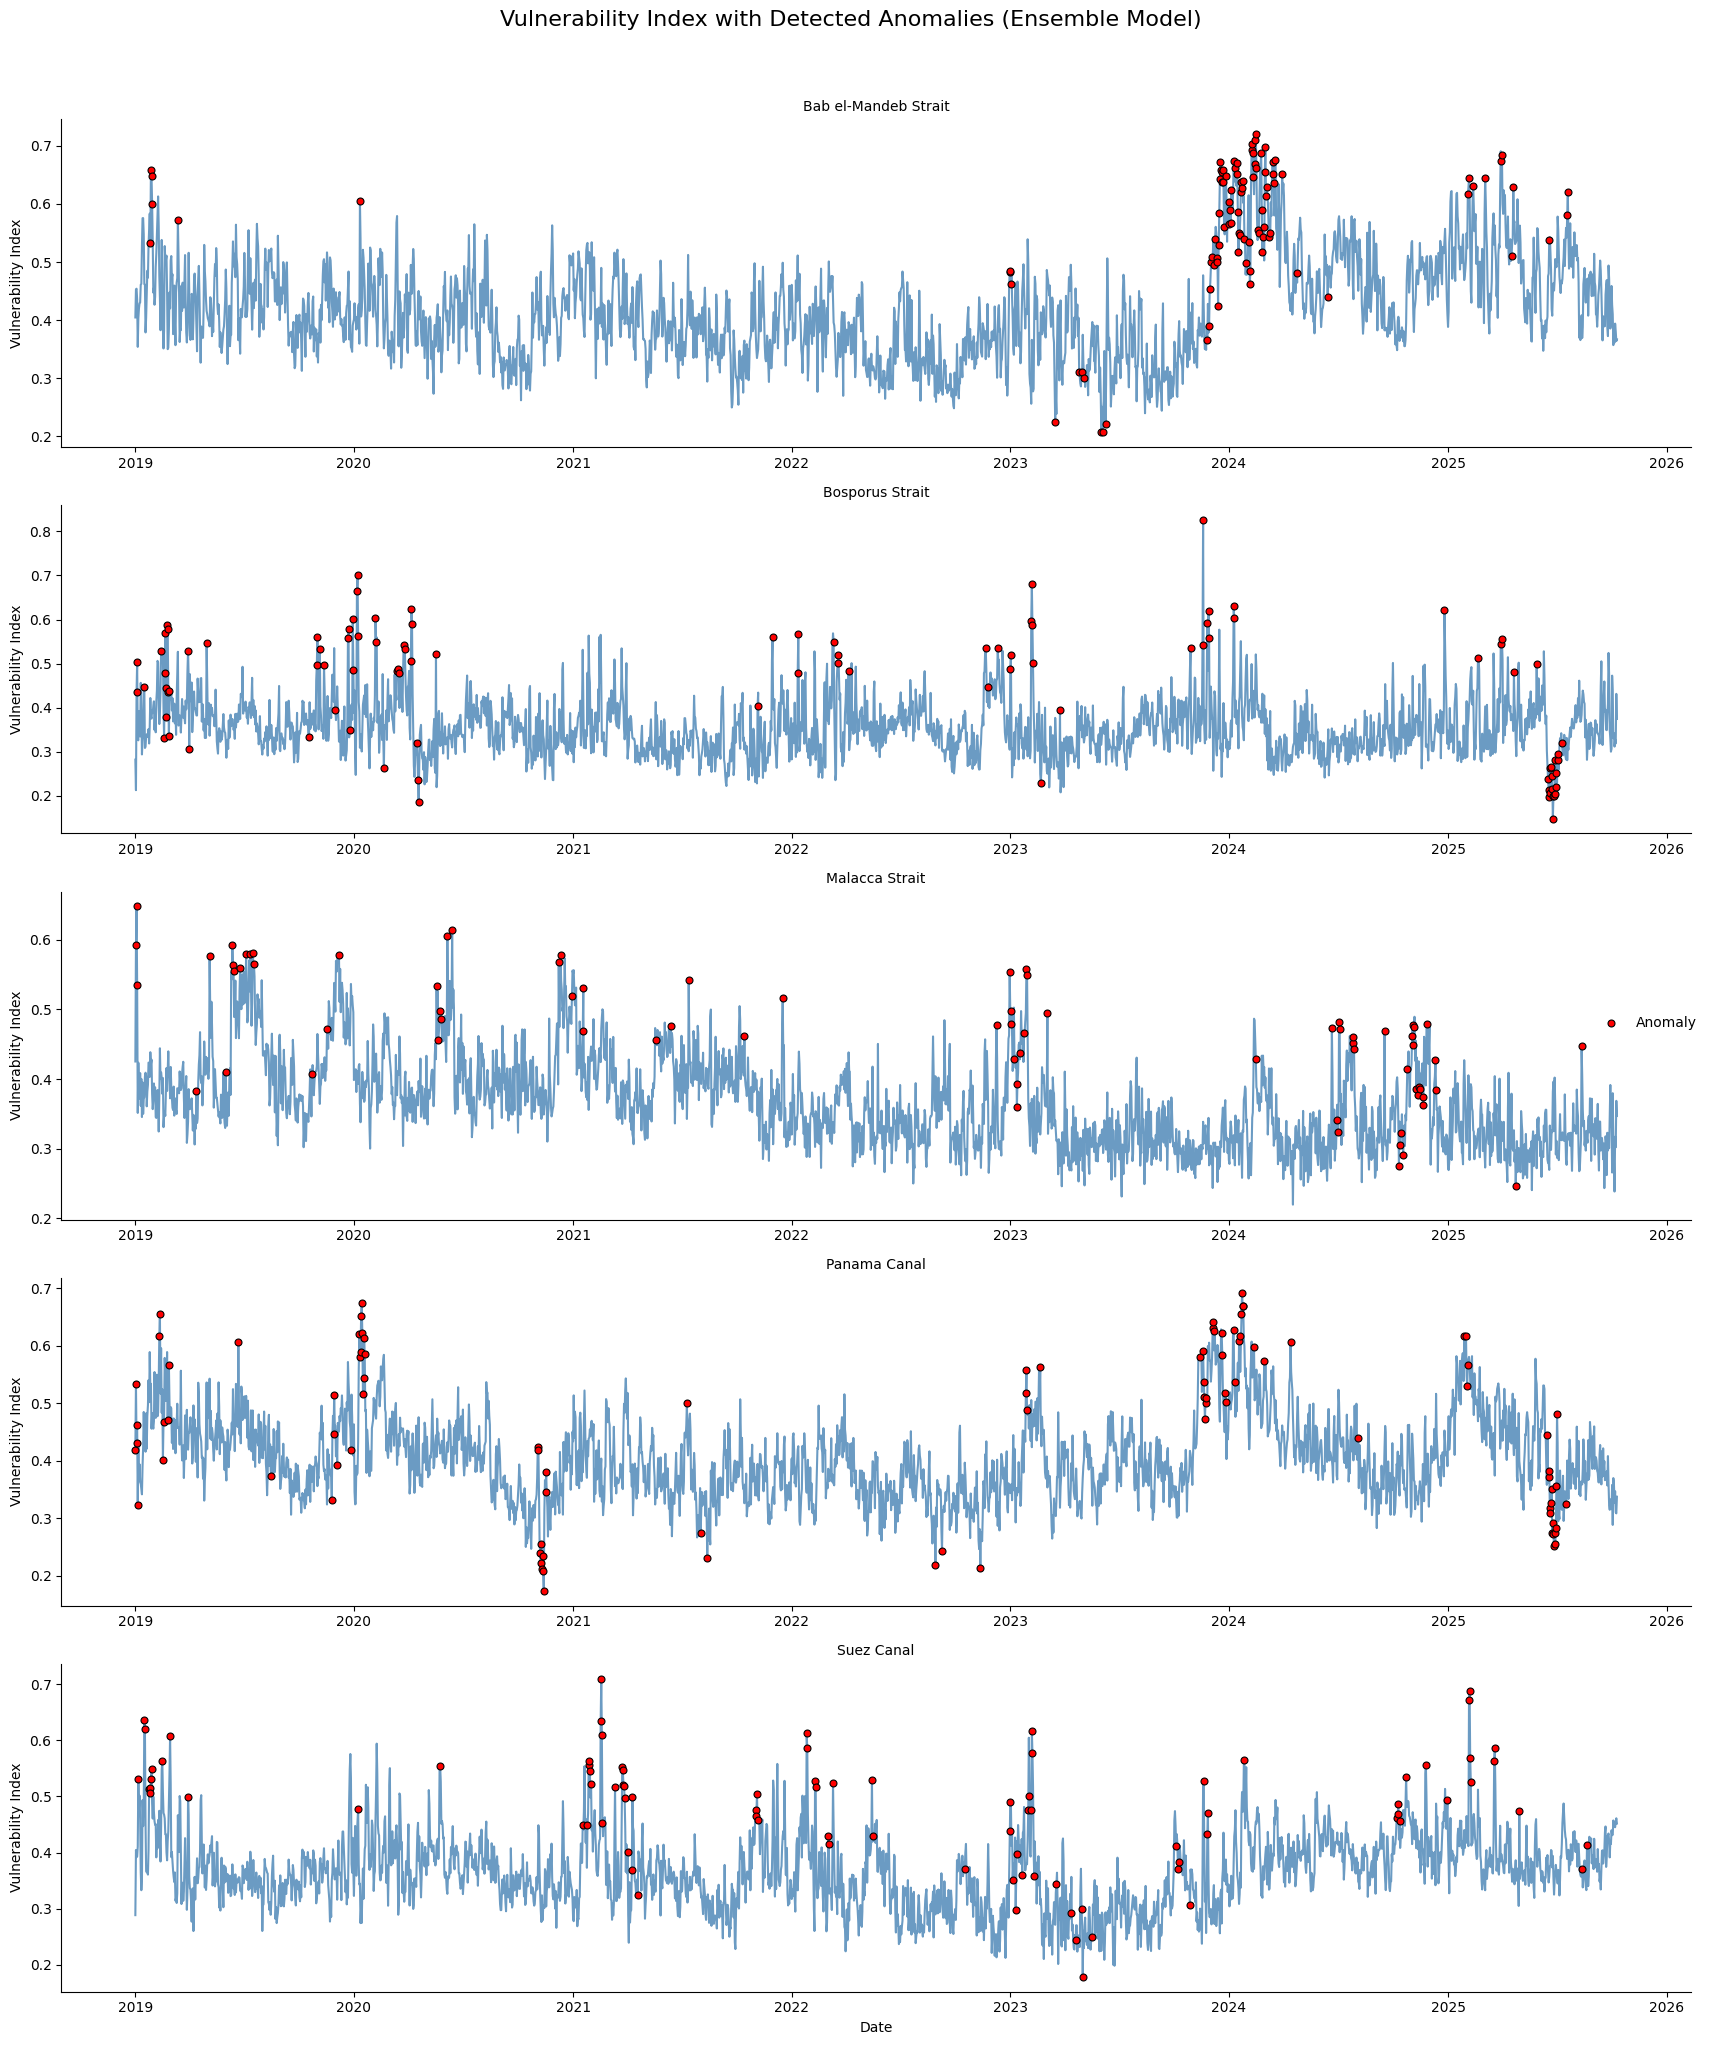

In [ ]:
# Visualization - Final Ensemble Anomalies Timeline
print("\n--- Visualizing Final Ensemble Anomalies Timeline ---")

# Create a column for plotting the flagged points
master_df['anomaly_points'] = np.where(
    master_df['ensemble_anomaly'] == -1, 
    master_df['vulnerability_index'], 
    np.nan
)

# Use FacetGrid for a clean multi-plot layout
g = sns.FacetGrid(master_df, row="chokepoint_name", height=4, aspect=4, sharex=False, sharey=False)
g.map(sns.lineplot, "date", "vulnerability_index", color='steelblue', alpha=0.8)
g.map(sns.scatterplot, "date", "anomaly_points", color='red', s=100, ec='k', marker='.', zorder=5, label="Anomaly")

g.fig.suptitle('Vulnerability Index with Detected Anomalies (Ensemble Model)', y=1.02, fontsize=16)
g.set_titles("{row_name}")
g.set_axis_labels("Date", "Vulnerability Index")
g.add_legend()
plt.tight_layout()

plt.show()

In [12]:
output_path = os.path.join(processed_data_dir, 'master_df_with_anomalies.csv')

# Save the complete DataFrame with all model predictions and the ensemble flag
master_df.to_csv(output_path, index=False)

print(f"Full results with anomaly flags saved to: {output_path}")

Full results with anomaly flags saved to: processed_data/master_df_with_anomalies.csv
